# Eikonal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

############################################################################################################
# |\nabla u| = f

# ((u - a1)^+)^2 + ((u - a2)^+)^2 = f^2 h^2


def calculate_unique_solution(a, b, f, h):

    d = abs(a - b)
    if d >= f * h:
        return min(a, b) + f * h
    else:
        return (a + b + np.sqrt(2 * f * f * h * h - (a - b) ** 2)) / 2


def sweeping_over_I_J_K(u, I, J, f, h):
    # print("Sweeping start...")
    m = len(I)
    n = len(J)
    for i in I:
        for j in J:
            if i == 0:
                uxmin = u[i + 1, j]
            elif i == m - 1:
                uxmin = u[i - 1, j]
            else:
                uxmin = np.min([u[i - 1, j], u[i + 1, j]])

            if j == 0:
                uymin = u[i, j + 1]
            elif j == n - 1:
                uymin = u[i, j - 1]
            else:
                uymin = np.min([u[i, j - 1], u[i, j + 1]])

            u_new = calculate_unique_solution(uxmin, uymin, f[i, j], h)

            u[i, j] = np.min([u_new, u[i, j]])

    return u


def sweeping(u, f, h):

    s = 1.0 / f  ## slowness

    m, n = u.shape
    I = list(range(m))
    iI = I[::-1]
    J = list(range(n))
    iJ = J[::-1]

    u = sweeping_over_I_J_K(u, I, J, s, h)
    u = sweeping_over_I_J_K(u, iI, J, s, h)
    u = sweeping_over_I_J_K(u, iI, iJ, s, h)
    u = sweeping_over_I_J_K(u, I, iJ, s, h)

    return u


def eikonal_solve(u, f, h):

    for i in range(50):
        u_old = np.copy(u)
        u = sweeping(u, f, h)

        err = np.max(np.abs(u - u_old))
        print(f"Iteration {i}, Error = {err}")
        if err < 1e-6:
            break

    return u


def normalize(vars_, bounds):
    mean = torch.tensor(
        [
            [
                (bounds[0][0] + bounds[0][1]) / 2,
                (bounds[1][0] + bounds[1][1]) / 2,
                (bounds[2][0] + bounds[2][1]) / 2,
            ],
        ],
        dtype=torch.float32,
    )
    std = torch.tensor(
        [
            [
                (bounds[0][1] - bounds[0][0]) / 2,
                (bounds[1][1] - bounds[1][0]) / 2,
                (bounds[2][1] - bounds[2][0]) / 2,
            ]
        ],
        dtype=torch.float32,
    )
    vars = (vars_ - mean) / std
    vars = torch.tanh(vars)
    vars = (vars * std) + mean

    return vars


def traveltime(vars_, station_locs, phase_type, up, us, h, rgrid, zgrid, sigma=1, bounds=None):

    if bounds is not None:
        vars = normalize(vars_, bounds)
    else:
        vars = vars_

    r = torch.sqrt(torch.sum((vars[0, :2] - station_locs[:, :2]) ** 2, dim=-1))
    z = torch.abs(vars[0, 2] - station_locs[:, 2])

    r = r.unsqueeze(-1).unsqueeze(-1)
    z = z.unsqueeze(-1).unsqueeze(-1)

    magn = (
        1.0
        / (2.0 * np.pi * sigma)
        * torch.exp(-(((rgrid - r) / (np.sqrt(2 * sigma) * h)) ** 2 + ((zgrid - z) / (np.sqrt(2 * sigma) * h)) ** 2))
    )
    
    tp = torch.sum(up * magn, dim=(-1, -2))
    ts = torch.sum(us * magn, dim=(-1, -2))
    tt = torch.cat([tp[i].unsqueeze(0) if phase_type[i]=='p' else ts[i].unsqueeze(0) for i, _ in enumerate(phase_type)], 0)
    print(tt)
    return tt


def invert_location(
    data, event_t0, event_locs, station_locs, phase_type, weight, up, us, rgrid, zgrid, sigma=1, bounds=None
):
    t0_ = torch.tensor(event_t0, dtype=torch.float32, requires_grad=True)
    loc_ = torch.tensor(event_locs, dtype=torch.float32, requires_grad=True)
    if bounds is not None:
        loc = normalize(loc_, bounds)
        t0 = t0_
    else:
        loc = loc_
        t0 = t0_

    print("Initial:", t0_.data, loc_.data)

    station_locs = torch.tensor(station_locs, dtype=torch.float32)
    weight = torch.tensor(weight, dtype=torch.float32)
    data = torch.tensor(data, dtype=torch.float32)
    rgrid = torch.tensor(rgrid, dtype=torch.float32)
    zgrid = torch.tensor(zgrid, dtype=torch.float32)
    up = torch.tensor(up, dtype=torch.float32)
    us = torch.tensor(us, dtype=torch.float32)

    p_index = None
    optimizer = optim.LBFGS(params=[t0_, loc_], max_iter=1000, line_search_fn="strong_wolfe")
    # optimizer = optim.LBFGS(params=[loc_], max_iter=1000, line_search_fn="strong_wolfe")

    def closure():
        optimizer.zero_grad()
        tt = t0_[0] + traveltime(loc_, station_locs, phase_type, up, us, rgrid, zgrid, sigma, bounds=bounds)
        # loss = F.mse_loss(data, tt)
        loss = F.huber_loss(data, tt)
        loss.backward(retain_graph=True)
        return loss

    optimizer.step(closure)

    if bounds is not None:
        loc = normalize(loc_, bounds)
        t0 = t0_
    else:
        loc = loc_
        t0 = t0_
    return torch.cat((loc, t0), 1).detach().numpy()

In [ ]:
zgrid.shape

In [ ]:
upt = torch.tensor(up, dtype=torch.float32)
ust = torch.tensor(us, dtype=torch.float32)

In [ ]:
a = torch.tensor(10, dtype=torch.float32)

In [ ]:
torch.floor(a.div(3)) * 3

In [ ]:
def interp(X, h, input):
    # the origin is 1
    ir0 = torch.floor(input[0].div(h)).type(torch.long)
    ir1 = ir0 + 1
    iz0 = torch.floor(input[1].div(h)).type(torch.long)
    iz1 = iz0 + 1
    print(ir0, ir1, iz0, iz1)
    r0 = ir0 * h
    z0 = iz0 * h

    Ia = X[ir0, iz1]
    Ib = X[ir1, iz1]
    Ic = X[ir0, iz0]
    Id = X[ir1, iz0]

    return ((Ib-Ia) * (input[0]-r0)/h + Ia - (Id-Ic) * (input[0]-r0)/h - Ic) * (input[1]-z0)/h + (Id-Ic) * (input[0]-r0)/h + Ic


In [ ]:
interp(upt, h, torch.tensor([753.4, 73.2], dtype=torch.float32))

In [ ]:
fp(753.4, 73.2)

In [ ]:
def traveltime(vars_, station_locs, phase_type, up, us,h, rgrid, zgrid, sigma=1, bounds=None):

    if bounds is not None:
        vars = normalize(vars_, bounds)
    else:
        vars = vars_

    r = torch.sqrt(torch.sum((vars[0, :2] - station_locs[:, :2]) ** 2, dim=-1))
    z = torch.abs(vars[0, 2] - station_locs[:, 2])

    r0 = 
    r = r.unsqueeze(-1).unsqueeze(-1)
    z = z.unsqueeze(-1).unsqueeze(-1)

    magn = (
        1.0
        / (2.0 * np.pi * sigma)
        * torch.exp(-(((rgrid - r) / (np.sqrt(2 * sigma) * h)) ** 2 + ((zgrid - z) / (np.sqrt(2 * sigma) * h)) ** 2))
    )
    
    tp = torch.sum(up * magn, dim=(-1, -2))
    ts = torch.sum(us * magn, dim=(-1, -2))
    tt = torch.cat([tp[i].unsqueeze(0) if phase_type[i]=='p' else ts[i].unsqueeze(0) for i, _ in enumerate(phase_type)], 0)
    print(tt)
    return tt

## 1D test

In [ ]:
import numpy as np
d, Vpv, Vph, Vsv, Vsh = np.loadtxt('PREM.csv', usecols=(1, 3, 4, 5, 6), unpack=True, skiprows=1)
Vp = np.sqrt((Vpv**2 + 4 * Vph**2)/5)
Vs = np.sqrt((2 * Vsv**2 + Vsh**2)/3)

In [ ]:
xlim = [0, 100]
ylim = [0, 100]
zlim = [0, 100]  ## depth
h = 0.3

rlim = [0, ((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2) ** 0.5]

rx = np.arange(rlim[0], rlim[1] + h, h)
zx = np.arange(zlim[0], zlim[1] + h, h)
m = len(rx)
n = len(zx)
dr = h
dz = h

vp = np.tile(np.interp(zx, d, Vp), (m, 1))
vs = np.tile(np.interp(zx, d, Vs), (m, 1))

In [ ]:
up = 1000 * np.ones((m, n))
up[0, 0] = 0.0
up = eikonal_solve(up, vp, h)

us = 1000 * np.ones((m, n))
us[0, 0] = 0.0
us = eikonal_solve(us, vs, h)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
up = np.loadtxt("up.csv")
us = np.loadtxt("us.csv")
############################## Check eikonal ##################################
# plt.figure(figsize=(10, 10))
rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij")
up_true = np.sqrt((rgrid - 0) ** 2 + (zgrid - 0) ** 2) / np.mean(vp)
us_true = np.sqrt((rgrid - 0) ** 2 + (zgrid - 0) ** 2) / np.mean(vs)

fig, axes = plt.subplots(2, 1, figsize=(16, 16 * n / m * 2))
im0 = axes[0].pcolormesh(rx, zx, up.T)
axes[0].axis("scaled")
axes[0].invert_yaxis()
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].pcolormesh(rx, zx, (up - up_true).T, vmax=up.max(), vmin=up.min())
axes[1].axis("scaled")
axes[1].invert_yaxis()
fig.colorbar(im1, ax=axes[1])

fig.savefig("test_vp.pdf")

fig, axes = plt.subplots(2, 1, figsize=(16, 16 * n / m * 2))
im0 = axes[0].pcolormesh(rx, zx, us.T)
axes[0].axis("scaled")
axes[0].invert_yaxis()
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].pcolormesh(rx, zx, (us - us_true).T, vmax=up.max(), vmin=up.min())
axes[1].axis("scaled")
axes[1].invert_yaxis()
fig.colorbar(im1, ax=axes[1])

fig.savefig("test_vs.pdf")

In [ ]:
############################# Check traveltime extraction ###################################
sigma = 2 * h
event_locs = np.array([[15, 15, 18]])  # (1, 3)
station_locs = np.array([[10, 10, 0], [20, 10, 0], [10, 20, 0], [20, 20, 0]])  # (nsta, 3)
# station_locs = np.array([[10, 10, 0], [100, 10, 0], [200, 200, 0], [300, 20, 0]])  # (nsta, 3)
r = np.sqrt(np.sum((event_locs[0, :2] - station_locs[:, :2]) ** 2, axis=-1))  # (nsta, 3)
z = np.abs(event_locs[0:1, 2] - station_locs[:, 2])  # (nsta, 1)
# r = np.array([rlim[-1] - 5 * h])
# z = np.array([zlim[-1] - 5 * h])

r = r[:, np.newaxis, np.newaxis]
z = z[:, np.newaxis, np.newaxis]
rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij")

magn = (
    1.0
    / (2.0 * np.pi * sigma)
    * np.exp(-(((rgrid - r) / (np.sqrt(2 * sigma) * h)) ** 2 + ((zgrid - z) / (np.sqrt(2 * sigma) * h)) ** 2))
)

tp = np.sum(up * magn, axis=(-1, -2))
ts = np.sum(us * magn, axis=(-1, -2))

# print(up.shape, magn.shape)

tp_true = (r[:, 0, 0] ** 2 + z[:, 0, 0] ** 2) ** 0.5 / np.mean(vp)
ts_true = (r[:, 0, 0] ** 2 + z[:, 0, 0] ** 2) ** 0.5 / np.mean(vs)

print(f"tp = {tp}, tp_true = {tp_true}")
print(f"ts = {ts}, ts_true = {ts_true}")

In [ ]:


############################# Inverting earthquake locations ###################################
phase_type = ['p', 's', 'p', 's']
data = np.array([tp[i] if phase_type[i]=='p' else ts[i] for i, _ in enumerate(phase_type)])
# data = np.concatenate([tp_true, ts_true])
weight = np.ones_like(tp)
bounds = [[0, 30], [0, 30], [0, 20]]
event_t0 = np.array([[0.0]])
event_locs = np.array(
    [
        [
            (bounds[0][0] + bounds[0][1]) / 2,
            (bounds[1][0] + bounds[1][1]) / 2,
            (bounds[2][0] + bounds[2][1]) / 2,
        ]
    ]
)
# event_locs = np.array([[15, 15, 18]])
# bounds = None
print(event_t0.shape, event_locs.shape, data.shape)
var = invert_location(
    data, event_t0, event_locs, station_locs, np.array(['p', 's', 'p', 's']), weight, up, us, rgrid, zgrid, sigma=0.6, bounds=bounds
)

## Test on real data

In [ ]:
import pandas as pd
from pyproj import Proj
from obspy import UTCDateTime

picks = pd.read_csv('picks_0703.csv', delimiter = '\t')
stations = pd.read_csv('stations.csv', delimiter = '\t')
event_syn = pd.read_csv('events.csv', delimiter='\t')

picks = picks.sort_values("timestamp", ignore_index = True)
config = {}
config["center"] = (-156, 55)
config["xlim_degree"] = [-164, -148]
config["ylim_degree"] = [50, 60]
config["starttime"] = UTCDateTime("20180101T00:00:00")
config["endtime"] = UTCDateTime("20200101T00:00:00")
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
xd = proj(longitude=config["xlim_degree"][0], latitude=config["ylim_degree"][0])
yd = proj(longitude=config["xlim_degree"][1], latitude=config["ylim_degree"][1])
config["x(km)"] = [xd[0], yd[0]]
config["y(km)"] = [xd[1], yd[1]]
config["z(km)"] = (0, 200)
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["covariance_prior"] = [500, 500]
config["method"] = "BGMM"
config["oversample_factor"] = 9
config["use_dbscan"] = True
config["use_amplitude"] = False
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 100
config["dbscan_min_samples"] = 3
config["min_picks_per_eq"] = 10
config["max_sigma11"] = 100
config["max_sigma22"] = 100
config["max_sigma12"] = 100

stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
event_syn[["x(km)", "y(km)"]] = event_syn.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

In [ ]:
picks = picks.merge(stations, "outer", on="id")
picks = picks.merge(event_syn, "outer", on="evid")
picks = picks.dropna()
picks['arrival'] = picks.apply(lambda x: UTCDateTime(x["timestamp"]) - UTCDateTime(x["time"]), axis = 1)

In [ ]:
import numpy as np
d, Vpv, Vph, Vsv, Vsh = np.loadtxt('PREM.csv', usecols=(1, 3, 4, 5, 6), unpack=True, skiprows=1)
Vp = np.sqrt((Vpv**2 + 4 * Vph**2)/5)
Vs = np.sqrt((2 * Vsv**2 + Vsh**2)/3)

xlim = config['x(km)']
ylim = config['y(km)']
zlim = config['z(km)']  ## depth
h = 1
sigma = 2 * h

rlim = [0, ((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2) ** 0.5]

rx = np.arange(rlim[0], rlim[1] + h, h)
zx = np.arange(zlim[0], zlim[1] + h, h)
m = len(rx)
n = len(zx)
dr = h
dz = h

vp = np.tile(np.interp(zx, d, Vp), (m, 1))
vs = np.tile(np.interp(zx, d, Vs), (m, 1))

up = np.loadtxt('up.csv')
us = np.loadtxt('us.csv')
# up = 1000 * np.ones((m, n))
# up[0, 0] = 0.0
# up = eikonal_solve(up, vp, h)

# us = 1000 * np.ones((m, n))
# us[0, 0] = 0.0
# us = eikonal_solve(us, vs, h)

In [ ]:
np.savetxt('up.csv', up)
np.savetxt('us.csv', us)

In [ ]:
rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij", sparse = True)

In [ ]:
import scipy
fp = scipy.interpolate.interp2d(rgrid,zgrid,up.T, kind='cubic')
fs = scipy.interpolate.interp2d(rgrid,zgrid,us.T, kind='cubic')
fp(100, 5)

In [ ]:
picks[picks['evid']=='0188gbpzb2']

In [ ]:
import scipy
timed = []
timed_cons = []
for ev in set(picks.evid):
    event_loc = np.array([np.hstack([event_syn[event_syn['evid']==ev]['x(km)'], event_syn[event_syn['evid']==ev]['y(km)'], event_syn[event_syn['evid']==ev]['depth']])])
    picks_e = picks[picks['evid']==ev]
    station_locs = np.column_stack([picks_e['x(km)_x'], picks_e['y(km)_x'], picks_e['z(km)']])
    phase_type = np.array(picks_e['type'])

    r = np.sqrt(np.sum((event_loc[:, :2] - station_locs[:, :2]) ** 2, axis=-1))  # (nsta, 3)
    z = np.abs(event_loc[0:1, 2] - station_locs[:, 2])  # (nsta, 1)
    # r = r[:, np.newaxis, np.newaxis]
    # z = z[:, np.newaxis, np.newaxis]
    h = 1
    sigma = 2 * h
    rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij", sparse = True)
    # rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij")
    
    
    # magn = (
    #     1.0
    #     / (2.0 * np.pi * sigma)
    #     * np.exp(-(((rgrid - r) / (np.sqrt(2 * sigma) * h)) ** 2 + ((zgrid - z) / (np.sqrt(2 * sigma) * h)) ** 2))
    # )
    fp = scipy.interpolate.interp2d(rgrid,zgrid,up.T, kind='cubic')
    fs = scipy.interpolate.interp2d(rgrid,zgrid,us.T, kind='cubic')
    # tp = np.diag(fp(r, z))
    # ts = np.diag(fs(r, z))
    
    # tp = np.sum(up * magn, axis=(-1, -2))
    # ts = np.sum(us * magn, axis=(-1, -2))
    t = np.array([fp(r[i], z[i]) if phase_type[i]=='P' else fs(r[i], z[i]) for i, _ in enumerate(phase_type)])
    t = np.squeeze(t)
    tp_cons = (r ** 2 + z ** 2) ** 0.5 / 6
    ts_cons = (r ** 2 + z ** 2) ** 0.5 / (6/1.73)
    t_cons = np.array([tp_cons[i] if phase_type[i]=='P' else ts_cons[i] for i, _ in enumerate(phase_type)])

    if len(t) > 0:
        timed.extend(list(t-np.array(picks_e['arrival'])))
        timed_cons.extend(t_cons - np.array(picks_e['arrival']))

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.hist(timed, range=[-50,50], bins=50)
plt.title('1d Velocity')
plt.xlabel('Time Difference (s)')
plt.subplot(1,2,2)
plt.hist(timed_cons, range=[-50,50], bins=50)
plt.title('Const Velocity')
plt.xlabel('Time Difference (s)')

In [ ]:
station_locs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

############################################################################################################
# |\nabla u| = f

# ((u - a1)^+)^2 + ((u - a2)^+)^2 = f^2 h^2


def calculate_unique_solution(a, b, f, h):

    d = abs(a - b)
    if d >= f * h:
        return min(a, b) + f * h
    else:
        return (a + b + np.sqrt(2 * f * f * h * h - (a - b) ** 2)) / 2


def sweeping_over_I_J_K(u, I, J, f, h):
    # print("Sweeping start...")
    m = len(I)
    n = len(J)
    for i in I:
        for j in J:
            if i == 0:
                uxmin = u[i + 1, j]
            elif i == m - 1:
                uxmin = u[i - 1, j]
            else:
                uxmin = np.min([u[i - 1, j], u[i + 1, j]])

            if j == 0:
                uymin = u[i, j + 1]
            elif j == n - 1:
                uymin = u[i, j - 1]
            else:
                uymin = np.min([u[i, j - 1], u[i, j + 1]])

            u_new = calculate_unique_solution(uxmin, uymin, f[i, j], h)

            u[i, j] = np.min([u_new, u[i, j]])

    return u


def sweeping(u, f, h):

    s = 1.0 / f  ## slowness

    m, n = u.shape
    I = list(range(m))
    iI = I[::-1]
    J = list(range(n))
    iJ = J[::-1]

    u = sweeping_over_I_J_K(u, I, J, s, h)
    u = sweeping_over_I_J_K(u, iI, J, s, h)
    u = sweeping_over_I_J_K(u, iI, iJ, s, h)
    u = sweeping_over_I_J_K(u, I, iJ, s, h)

    return u


def eikonal_solve(u, f, h):

    for i in range(50):
        u_old = np.copy(u)
        u = sweeping(u, f, h)

        err = np.max(np.abs(u - u_old))

        if err < 1e-6:
            break

    return u


def normalize(vars_, bounds):
    mean = torch.tensor(
        [
            [
                (bounds[0][0] + bounds[0][1]) / 2,
                (bounds[1][0] + bounds[1][1]) / 2,
                (bounds[2][0] + bounds[2][1]) / 2,
            ],
        ],
        dtype=torch.float32,
    )
    std = torch.tensor(
        [
            [
                (bounds[0][1] - bounds[0][0]) / 2,
                (bounds[1][1] - bounds[1][0]) / 2,
                (bounds[2][1] - bounds[2][0]) / 2,
            ]
        ],
        dtype=torch.float32,
    )
    vars = (vars_ - mean) / std
    vars = torch.tanh(vars)
    vars = (vars * std) + mean

    return vars


def traveltime(vars_, station_locs, phase_type, up, us, h, rgrid, zgrid, bounds=None):

    def interp(X, h, input):
        # the origin is (0,0)
        ir0 = torch.floor(input[0].div(h)).type(torch.long)
        ir1 = ir0 + 1
        iz0 = torch.floor(input[1].div(h)).type(torch.long)
        iz1 = iz0 + 1
        if iz0 >= zgrid.shape[1]:
            iz0 = zgrid.shape[1] - 1
        if iz1 >= zgrid.shape[1]:
            iz1 = zgrid.shape[1] - 1
        r0 = ir0 * h
        z0 = iz0 * h

        Ia = X[ir0, iz1]
        Ib = X[ir1, iz1]
        Ic = X[ir0, iz0]
        Id = X[ir1, iz0]

        return ((Ib-Ia) * (input[0]-r0)/h + Ia - (Id-Ic) * (input[0]-r0)/h - Ic) * (input[1]-z0)/h + (Id-Ic) * (input[0]-r0)/h + Ic

    if bounds is not None:
        vars = normalize(vars_, bounds)
    else:
        vars = vars_

    r = torch.sqrt(torch.sum((vars[0, :2] - station_locs[:, :2]) ** 2, dim=-1)).unsqueeze(1)
    z = torch.abs(vars[0, 2] - station_locs[:, 2]).unsqueeze(1)
    t = torch.cat([interp(up, h, torch.cat([r[i], z[i]])).unsqueeze(0) if phase_type[i]=='p' else interp(us, h, torch.cat([r[i], z[i]])).unsqueeze(0) for i, _ in enumerate(phase_type)], 0)
    print(t)
    return t


def invert_location(
    data, event_t0, event_locs, station_locs, phase_type, weight, up, us, h, rgrid, zgrid, bounds=None
):
    t0_ = torch.tensor(event_t0, dtype=torch.float32, requires_grad=True)
    loc_ = torch.tensor(event_locs, dtype=torch.float32, requires_grad=True)
    if bounds is not None:
        loc = normalize(loc_, bounds)
        t0 = t0_
    else:
        loc = loc_
        t0 = t0_
    station_locs = torch.tensor(station_locs, dtype=torch.float32)
    weight = torch.tensor(weight, dtype=torch.float32)
    data = torch.tensor(data, dtype=torch.float32)
    rgrid = torch.tensor(rgrid, dtype=torch.float32)
    zgrid = torch.tensor(zgrid, dtype=torch.float32)
    up = torch.tensor(up, dtype=torch.float32)
    us = torch.tensor(us, dtype=torch.float32)
    optimizer = optim.LBFGS(params=[t0_, loc_], max_iter=1000, line_search_fn="strong_wolfe")

    def closure():
        optimizer.zero_grad()
        tt = t0_[0] + traveltime(loc_, station_locs, phase_type, up, us, h, rgrid, zgrid, bounds=bounds)
        loss = F.huber_loss(data, tt)
        loss.backward(retain_graph=True)
        return loss

    optimizer.step(closure)

    if bounds is not None:
        loc = normalize(loc_, bounds)
        t0 = t0_
    else:
        loc = loc_
        t0 = t0_
    print(loc, t0)
    return torch.cat((loc.squeeze(0), t0), 0).detach().numpy()

In [ ]:
event_syn[event_syn['evid']=='0188gbpzb2']

In [ ]:
############################# Inverting earthquake locations ###################################
ev = '0188gbpzb2'
event_loc = np.array([np.hstack([event_syn[event_syn['evid']==ev]['x(km)'], event_syn[event_syn['evid']==ev]['y(km)'], event_syn[event_syn['evid']==ev]['depth']])])
picks_e = picks[picks['evid']==ev]
station_locs = np.column_stack([picks_e['x(km)_x'], picks_e['y(km)_x'], picks_e['z(km)']])
phase_type = np.array(picks_e['type'])

r = np.sqrt(np.sum((event_loc[:, :2] - station_locs[:, :2]) ** 2, axis=-1))  # (nsta, 3)
z = np.abs(event_loc[0:1, 2] - station_locs[:, 2])  # (nsta, 1)
h = 1
rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij", sparse = True)
fp = scipy.interpolate.interp2d(rgrid,zgrid,up.T, kind='cubic')
fs = scipy.interpolate.interp2d(rgrid,zgrid,us.T, kind='cubic')
t = np.array([fp(r[i], z[i]) if phase_type[i]=='P' else fs(r[i], z[i]) for i, _ in enumerate(phase_type)])
t = np.squeeze(t)

weight = np.ones_like(t)
bounds = [xlim, ylim, zlim]
event_t0 = np.array([0.0])
event_locs = np.array(
    [
        [
            (bounds[0][0] + bounds[0][1]) / 2,
            (bounds[1][0] + bounds[1][1]) / 2,
            (bounds[2][0] + bounds[2][1]) / 2,
        ]
    ]
)


In [ ]:
t

In [ ]:
t

In [ ]:
# event_locs = np.array([[15, 15, 18]])
# bounds = None
print(event_t0.shape, event_locs.shape, t.shape) 
print(event_locs)
var = invert_location(
    t, event_t0, event_locs, station_locs, phase_type, weight, up, us, h, rgrid, zgrid, bounds=bounds
)

# 1D vel GaMMA test

In [1]:
import pandas as pd
from pyproj import Proj
from obspy import UTCDateTime
import numpy as np
from gamma.utils import association

picks = pd.read_csv('picks_0703.csv', delimiter = '\t')
picks['timestamp'] = picks['timestamp'].apply(lambda x: pd.Timestamp(x))
# picks = picks[picks['timestamp'] > pd.Timestamp(2018, 7, 3, 7, 20)]
# picks = picks[picks['timestamp'] < pd.Timestamp(2018, 7, 3, 7, 30)]
stations = pd.read_csv('stations.csv', delimiter = '\t')
event_syn = pd.read_csv('events.csv', delimiter='\t')
up = np.loadtxt("up.csv")
us = np.loadtxt("us.csv")
d, Vpv, Vph, Vsv, Vsh = np.loadtxt('PREM.csv', usecols=(1, 3, 4, 5, 6), unpack=True, skiprows=1)
Vp = np.sqrt((Vpv**2 + 4 * Vph**2)/5)
Vs = np.sqrt((2 * Vsv**2 + Vsh**2)/3)

/mnt/home/jieyaqi/anaconda3/envs/gamma_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
picks = picks.sort_values("timestamp", ignore_index = True)
config = {}
config["center"] = (-156, 55)
config["xlim_degree"] = [-164, -148]
config["ylim_degree"] = [50, 60]
config["starttime"] = UTCDateTime("20180101T00:00:00")
config["endtime"] = UTCDateTime("20200101T00:00:00")
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
xd = proj(longitude=config["xlim_degree"][0], latitude=config["ylim_degree"][0])
yd = proj(longitude=config["xlim_degree"][1], latitude=config["ylim_degree"][1])
config["x(km)"] = [xd[0], yd[0]]
config["y(km)"] = [xd[1], yd[1]]
config["z(km)"] = (0, 200)
# config["vel"] = {"p": Vp, "s": Vs, "depth": d}
config["vel"] = {"p": 6, "s": 6/1.73}
config["eikonal"] = {"up": up, "us": us}
config["eikonal_grid"] = 1
config["covariance_prior"] = [500, 500]
config["method"] = "BGMM"
config["oversample_factor"] = 9
config["use_dbscan"] = True
config["use_amplitude"] = False
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 100
config["dbscan_min_samples"] = 3
config["min_picks_per_eq"] = 10
config["max_sigma11"] = 1000
config["max_sigma22"] = 1000
config["max_sigma12"] = 1000
config["ncpu"] = 10

stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

In [44]:
pickst = picks
event_idx0 = 0  ## current earthquake index
assignments = []
catalogs, assignments = association(
    pickst, 
    stations, 
    config,
    event_idx0,
    method=config["method"],
)
event_idx0 += len(catalogs)


catalogs = pd.DataFrame(catalogs, columns=["time"]+config["dims"]+["magnitude", "sigma_time", "sigma_amp", "cov_time_amp",  "event_index", "gamma_score"])
catalogs[["longitude","latitude"]] = catalogs.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
pickst = pickst.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
pickst = pickst.merge(stations, "outer", on="id")
pickst = pickst.dropna()

NameError: name 'stations' is not defined

In [1]:
import pandas as pd
from pyproj import Proj
from obspy import UTCDateTime
import numpy as np
from gamma.utils import association

picks = pd.read_csv(r'../picks_gamma.csv', delimiter = '\t')
picks['timestamp'] = picks['timestamp'].apply(lambda x: pd.Timestamp(x))
event_syn = pd.read_csv(r'../data/events.csv', delimiter='\t')
catalogs = pd.read_csv(r'../catalogs_gamma.csv', delimiter = '\t')

# picks = pd.read_csv(r'../picks_syn.csv', delimiter = '\t')
# picks['timestamp'] = picks['timestamp'].apply(lambda x: pd.Timestamp(x))
# event_syn = pd.read_csv(r'../event_syn.csv', delimiter='\t')
# catalogs = pd.read_csv(r'../catalogs_syn.csv', delimiter = '\t')
pickst = picks

(0.0, 238.6)

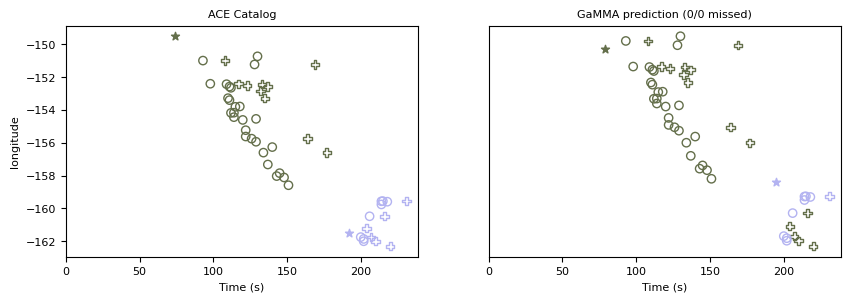

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# t0 = pd.Timestamp(2019, 8, 28, 17, 10)
# t1 = pd.Timestamp(2019, 8, 28, 17, 20)
t0 = pd.Timestamp(2018, 7, 9, 20, 53)
t1 = pd.Timestamp(2018, 7, 9, 21)
picks_syn = pickst[(pickst["timestamp"] >= t0)]
picks_syn = picks_syn[(picks_syn["timestamp"] < t1)]
picks_syn['timediff'] = picks_syn['timestamp'].apply(lambda x: x - t0)
picks_syn = picks_syn.astype({'timediff':'timedelta64[s]'})
catalogs['timestamp'] = catalogs['time'].apply(lambda x: pd.Timestamp(x))
catalogs['timediff'] = catalogs['timestamp'].apply(lambda x: x - t0)
catalogs = catalogs.astype({'timediff':'timedelta64[s]'})
event_syn['timestamp'] = event_syn['time'].apply(lambda x: pd.Timestamp(x[:-1]))
event_syn['timediff'] = event_syn['timestamp'].apply(lambda x: x - t0)
event_syn = event_syn.astype({'timediff':'timedelta64[s]'})

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
color = ['#646F4B', '#b3b3f1', '#b4654a', 'c', 'm', 'blue', 'orange', 'yellow', 'green', 'red', 'purple', 'pink', 'darkblue', 'gray', 'lightpink', 'darkblue', 'lightgray']
p = picks_syn[picks_syn['type']=='P']
s = picks_syn[picks_syn['type']=='S']
for idx, eid in enumerate(sorted(set(picks_syn['evid']))):
    plt.scatter(p[p['evid'] == eid]["timediff"], p[p['evid'] == eid]["longitude"], marker = 'o', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(s[s['evid'] == eid]["timediff"], s[s['evid'] == eid]["longitude"], marker = 'P', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(event_syn[event_syn['evid'] == eid]['timediff'], event_syn[event_syn['evid'] == eid]['longitude'], marker = '*', edgecolors = color[idx], facecolors = color[idx])
plt.xlim(left = 0)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Time (s)', fontsize = 8)
plt.ylabel('longitude', fontsize = 8)
plt.title('ACE Catalog', fontsize = 8)

plt.subplot(1,2,2)
plt.scatter(p[p['event_index'] == -1]["timediff"], p[p['event_index'] == -1]["longitude"], marker = 'o', edgecolors = 'k', facecolors = 'none')
plt.scatter(s[s['event_index'] == -1]["timediff"], s[s['event_index'] == -1]["longitude"], marker = 'P', edgecolors = 'k', facecolors = 'none')
for idx, eid in enumerate(sorted(set(picks_syn['event_index']).difference([-1]))):
    plt.scatter(p[p['event_index'] == eid]["timediff"], p[p['event_index'] == eid]["longitude"], marker = 'o', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(s[s['event_index'] == eid]["timediff"], s[s['event_index'] == eid]["longitude"], marker = 'P', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(catalogs[catalogs['event_index'] == eid]['timediff'], catalogs[catalogs['event_index'] == eid]['longitude'], marker = '*', edgecolors = color[idx], facecolors = color[idx])
# plt.xlim(left = 0, right = 300)
plt.yticks([])
plt.xticks(fontsize = 8)
plt.xlabel('Time (s)', fontsize = 8)
pmiss = len(p[p['event_index'] == -1])
smiss = len(s[s['event_index'] == -1])
plt.title(f'GaMMA prediction ({pmiss}/{smiss} missed)', fontsize = 8)
plt.xlim(left = 0)
# plt.savefig('example10.pdf', format = 'pdf', bbox_inches = "tight")

In [45]:
def _CalFscore(det: list, obs: list, start: UTCDateTime, end: UTCDateTime, threshold: float):
    TP = []
    FN = []
    FP = []
    utc2str = lambda x: x.__unicode__()

    if det == None or len(det) == 0: 
        if obs == None or len(obs) == 0:
            pass
        else:
            i = 0
            while i < len(obs):
                if obs[i] >= start and obs[i] <= end:
                    FN.append(utc2str(obs[i]))
                i = i + 1
    else:
        if len(obs) == 0:
            FP = [utc2str(i) for i in det]
        else:
            i = j = 0
            TP = []
            FN = []
            FP = []
            
            while i < len(obs) and j < len(det) and obs[i] <= end:
                if obs[i] < start:
                    i = i + 1
                    continue
                elif abs(det[j]-obs[i]) <= threshold:
                    TP.append(utc2str(det[j]))
                    i = i + 1
                    j = j + 1
                elif obs[i] < det[j] - threshold:
                    FN.append(utc2str(obs[i]))
                    i = i + 1
                elif obs[i] > det[j] + threshold:
                    FP.append(utc2str(det[j]))
                    j = j + 1

            while j < len(det):
                FP.append(utc2str(det[j]))
                j = j + 1

            while i < len(obs) and obs[i] <= start:
                FN.append(utc2str(obs[i]))
                i = i + 1
    return TP, FN, FP

In [46]:
event_syn['time'] = event_syn['time'].apply(lambda x: UTCDateTime(x))
catalogs['time'] = catalogs['time'].apply(lambda x: UTCDateTime(x))
event_syn = event_syn.sort_values("time", ignore_index = True)
catalogs = catalogs.sort_values("time", ignore_index = True)
TP, FN, FP = _CalFscore(det = list(catalogs['time']), obs = event_syn['time'], start =  UTCDateTime(2018,1,1), end = UTCDateTime(2020, 1, 1), threshold = 60)
precision = len(TP)/(len(TP)+len(FP))
recall = len(TP)/(len(TP)+len(FN))
F1 = 2/((1/precision) + (1/recall))
print(f'TP:{len(TP)}, FN:{len(FN)}, FP:{len(FP)}, precision: {precision}, recall: {recall}, F1: {F1}')

TP:7127, FN:115, FP:465, precision: 0.9387513171759747, recall: 0.984120408726871, F1: 0.9609006336793853


In [47]:
FP

['2018-05-12T09:48:48.248000Z',
 '2018-05-15T11:25:08.992000Z',
 '2018-05-17T07:03:29.086000Z',
 '2018-05-17T20:51:17.711000Z',
 '2018-05-19T05:17:14.336000Z',
 '2018-05-22T02:27:43.398000Z',
 '2018-05-23T07:13:36.773000Z',
 '2018-05-23T09:16:08.773000Z',
 '2018-05-24T03:19:51.773000Z',
 '2018-05-24T16:38:34.586000Z',
 '2018-05-24T17:37:46.836000Z',
 '2018-05-24T18:08:35.711000Z',
 '2018-05-24T23:34:53.461000Z',
 '2018-05-25T06:03:54.336000Z',
 '2018-05-25T08:16:33.336000Z',
 '2018-05-25T20:26:52.586000Z',
 '2018-05-25T20:38:56.211000Z',
 '2018-05-26T01:57:57.336000Z',
 '2018-05-26T10:18:07.961000Z',
 '2018-05-28T12:49:44.711000Z',
 '2018-05-30T09:31:53.961000Z',
 '2018-05-30T09:32:00.086000Z',
 '2018-05-30T09:53:22.086000Z',
 '2018-06-01T02:43:09.086000Z',
 '2018-06-01T05:09:01.586000Z',
 '2018-06-01T07:51:11.461000Z',
 '2018-06-01T17:08:03.961000Z',
 '2018-06-02T15:35:26.336000Z',
 '2018-06-07T01:02:21.711000Z',
 '2018-06-08T17:09:06.961000Z',
 '2018-06-12T02:22:49.961000Z',
 '2018-0

In [5]:
FN

['2018-11-25T01:57:39.784000Z',
 '2018-12-29T21:46:09.605000Z',
 '2018-12-31T03:19:30.003000Z',
 '2018-12-31T03:45:21.226000Z']

In [191]:
picks_syn

,id,evid,timestamp,type,time_idx,prob,amp,event_index,gamma_score,longitude,latitude,elevation(m),x(km),y(km),z(km),timediff
672,AV.KAHG..BH,018grok4cw,2018-12-31 02:36:59.816000,P,2018-12-31,1.0,3226.020400,652.0,0.007986,-154.5484,58.4933,923.0,84.727155,390.015406,-0.9230,9419.0
673,AV.KAHG..BH,018grspgo0,2018-12-31 09:32:50.318000,P,2018-12-31,1.0,99.693105,607.0,0.015838,-154.5484,58.4933,923.0,84.727155,390.015406,-0.9230,34370.0
1346,AV.KAHC..EH,018grspgo0,2018-12-31 09:32:50.486000,P,2018-12-31,1.0,445.261013,607.0,0.017861,-155.0081,58.6483,1250.0,57.646723,406.817098,-1.2500,34370.0
2161,XO.ET20..HH,018grok4cw,2018-12-31 02:36:54.355000,P,2018-12-31,1.0,18163.271676,652.0,0.006656,-154.9716,58.1304,965.5,60.634370,349.117007,-0.9655,9414.0
2162,XO.ET20..HH,018grspgo0,2018-12-31 09:32:44.734000,P,2018-12-31,1.0,1107.547041,607.0,0.014980,-154.9716,58.1304,965.5,60.634370,349.117007,-0.9655,34364.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26964,XO.LT08..HH,018grspgo0,2018-12-31 09:32:32.214977,P,2018-12-31,1.0,3307.323408,607.0,0.012421,-156.5975,55.5883,-246.0,-37.675648,65.656886,0.2460,34352.0
26965,XO.LT08..HH,018grspgo0,2018-12-31 09:32:47.267977,S,2018-12-31,1.0,3307.323408,607.0,0.013180,-156.5975,55.5883,-246.0,-37.675648,65.656886,0.2460,34367.0
26966,XO.LT08..HH,018grspgo0,2018-12-31 09:32:47.351977,S,2018-12-31,1.0,3307.323408,-1.0,-1.000000,-156.5975,55.5883,-246.0,-37.675648,65.656886,0.2460,34367.0
26989,XO.LT03..HH,018grok4cw,2018-12-31 02:36:56.447000,P,2018-12-31,1.0,3873.744020,652.0,0.007042,-154.1665,57.8668,-202.0,108.880334,320.735682,0.2020,9416.0


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

csv = pd.read_csv(r'../PhaseNetPicks.csv')

In [15]:
len(set(csv['id']))

28

([<matplotlib.patches.Wedge at 0x2b5929e30370>,
 [Text(-0.2866006968736156, 1.0620075520219043, 'P (28293)'),
  Text(0.2866006968736155, -1.0620075520219043, 'S (20162)')])

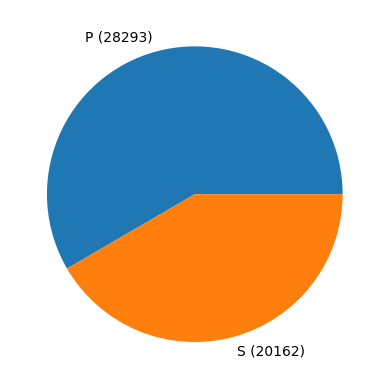

In [13]:
a = [len(csv[csv['type']=='P']), len(csv[csv['type']=='S'])]
plt.pie(a, labels=['P (28293)', 'S (20162)'])

# Penalty

In [ ]:
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from tqdm import tqdm

from gamma import BayesianGaussianMixture
from gamma import GaussianMixture, calc_amp, calc_time

to_seconds = lambda t: t.timestamp(tz="UTC")
from_seconds = lambda t: pd.Timestamp.utcfromtimestamp(t).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]
# to_seconds = lambda t: datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f").timestamp()
# from_seconds = lambda t: [datetime.utcfromtimestamp(x).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] for x in t]


def convert_picks_csv(picks, stations, config):
    # t = picks["timestamp"].apply(lambda x: x.timestamp()).to_numpy()
    if type(picks["timestamp"].iloc[0]) is str:
        picks.loc[:, "timestamp"] = picks["timestamp"].apply(lambda x: datetime.fromisoformat(x))
    t = (
        picks["timestamp"]
        .apply(lambda x: x.tz_convert("UTC").timestamp() if x.tzinfo is not None else x.tz_localize("UTC").timestamp())
        .to_numpy()
    )
    # t = picks["timestamp"].apply(lambda x: x.timestamp()).to_numpy()
    timestamp0 = np.min(t)
    t = t - timestamp0
    if config["use_amplitude"]:
        a = picks["amp"].apply(lambda x: np.log10(x * 1e2)).to_numpy()  ##cm/s
        data = np.stack([t, a]).T
    else:
        data = t[:, np.newaxis]
    meta = stations.merge(picks["id"], how="right", on="id")
    locs = meta[config["dims"]].to_numpy()
    phase_type = picks["type"].apply(lambda x: x.lower()).to_numpy()
    phase_weight = picks["prob"].to_numpy()[:, np.newaxis]
    pick_station_id = picks.apply(lambda x: x.id + "_" + x.type, axis=1).to_numpy()
    nan_idx = meta.isnull().any(axis=1)
    return (
        data[~nan_idx],
        locs[~nan_idx],
        phase_type[~nan_idx],
        phase_weight[~nan_idx],
        picks.index.to_numpy()[~nan_idx],
        pick_station_id[~nan_idx],
        timestamp0,
    )


def association(picks, stations, config, event_idx0=0, method="BGMM", **kwargs):

    data, locs, phase_type, phase_weight, pick_idx, pick_station_id, timestamp0 = convert_picks_csv(
        picks, stations, config
    )

    vel = config["vel"] if "vel" in config else {"p": 6.0, "s": 6.0 / 1.73}
    if "covariance_prior" in config:
        covariance_prior = config["covariance_prior"]
    else:
        covariance_prior = [5.0, 5.0]

    if ("use_dbscan" in config) and config["use_dbscan"]:
        db = DBSCAN(eps=config["dbscan_eps"], min_samples=config["dbscan_min_samples"]).fit(
            np.hstack([data[:, 0:1], locs[:, :2] / vel["p"]])
        )
        # db = DBSCAN(eps=config["dbscan_eps"], min_samples=config["dbscan_min_samples"]).fit(data[:, 0:1])
        labels = db.labels_
        unique_labels = set(labels)
    else:
        labels = np.zeros(len(data))
        unique_labels = [0]

    events = []
    assignment = []  ## from picks to events
    event_idx = event_idx0

    pbar = tqdm(total=len(data), desc="Association")
    for k in unique_labels:

        if k == -1:
            data_ = data[labels == k]
            pbar.set_description(f"Skip {len(data_)} picks")
            pbar.update(len(data_))
            continue

        class_mask = labels == k
        data_ = data[class_mask]
        locs_ = locs[class_mask]
        phase_type_ = phase_type[class_mask]
        phase_weight_ = phase_weight[class_mask]
        pick_idx_ = pick_idx[class_mask]
        pick_station_id_ = pick_station_id[class_mask]

        if len(pick_idx_) < config["min_picks_per_eq"]:
            pbar.set_description(f"Skip {len(data_)} picks")
            pbar.update(len(data_))
            continue

        if pbar is not None:
            pbar.set_description(f"Process {len(data_)} picks")
            pbar.update(len(data_))

        time_range = max(data_[:, 0].max() - data_[:, 0].min(), 1)

        ## initialization with 5 horizontal points and N//5 time points
        # initial_mode = "one_point"
        # initial_mode = "five_points"
        if "initial_mode" in config:
            initial_mode = config["initial_mode"]
        else:
            initial_mode = "one_point"
        if initial_mode == "five_points":
            num_event_loc_init = 5
            if "num_event_init" in config:
                num_event_init = config["num_event_init"]
            else:
                num_event_init = min(
                    max(int(len(data_) / num_sta * config["oversample_factor"]), 3),
                    max(len(data_) // num_event_loc_init, 1),
                )
            x0, xn = config["x(km)"]
            x1 = np.mean(config["x(km)"])
            if "y(km)" in config:
                y0, yn = config["y(km)"]
                y1 = np.mean(config["y(km)"])
            else:
                y0, yn = 0.0, 0.0
                y1 = 0.0
            if "z(km)" in config:
                z1 = np.mean(config["z(km)"])
            else:
                z1 = 0
            event_loc_init = [
                ((x0 + x1) / 2, (y0 + y1) / 2),
                ((x0 + x1) / 2, (yn + y1) / 2),
                ((xn + x1) / 2, (y0 + y1) / 2),
                ((xn + x1) / 2, (yn + y1) / 2),
                (x1, y1),
            ]
            num_event_time_init = max(num_event_init // num_event_loc_init, 1)
            if config["dims"] == ["x(km)", "y(km)", "z(km)"]:
                centers_init = np.vstack(
                    [
                        np.vstack(
                            [
                                np.ones(num_event_time_init) * x,
                                np.ones(num_event_time_init) * y,
                                np.ones(num_event_time_init) * z1,
                                np.linspace(
                                    data_[:, 0].min() - 0.1 * time_range,
                                    data_[:, 0].max() + 0.1 * time_range,
                                    num_event_time_init,
                                ),
                            ]
                        ).T
                        for x, y in event_loc_init
                    ]
                )
            elif config["dims"] == ["x(km)", "y(km)"]:
                centers_init = np.vstack(
                    [
                        np.vstack(
                            [
                                np.ones(num_event_time_init) * x,
                                np.ones(num_event_time_init) * y,
                                np.linspace(
                                    data_[:, 0].min() - 0.1 * time_range,
                                    data_[:, 0].max() + 0.1 * time_range,
                                    num_event_time_init,
                                ),
                            ]
                        ).T
                        for x, y in event_loc_init
                    ]
                )
            elif config["dims"] == ["x(km)"]:
                centers_init = np.vstack(
                    [
                        np.vstack(
                            [
                                np.ones(num_event_time_init) * x,
                                np.linspace(
                                    data_[:, 0].min() - 0.1 * time_range,
                                    data_[:, 0].max() + 0.1 * time_range,
                                    num_event_time_init,
                                ),
                            ]
                        ).T
                        for x, y in event_loc_init
                    ]
                )
            else:
                raise (ValueError("Unsupported dims"))

        ## initialization with 1 horizontal center points and N time points
        if (initial_mode == "one_point") or (len(data_) < len(centers_init)):

            num_sta = len(np.unique(locs_, axis=0))
            if "num_event_init" in config:
                num_event_init = config["num_event_init"]
            else:
                num_event_init = min(
                    max(int(len(data_) / num_sta * config["oversample_factor"]), 1),
                    len(data_),
                )
            x_init = np.ones(num_event_init) * np.mean(config["x(km)"])
            y_init = np.ones(num_event_init) * np.mean(config["y(km)"])
            z_init = np.ones(num_event_init) * np.mean(config["z(km)"])
            t_init = np.sort(data_[:, 0])[::len(data_[:, 0]) // num_event_init][:num_event_init]
            if config["dims"] == ["x(km)", "y(km)", "z(km)"]:
                centers_init = np.vstack(
                    [ x_init, y_init, z_init, t_init]
                ).T
            elif config["dims"] == ["x(km)", "y(km)"]:
                centers_init = np.vstack(
                    [x_init, y_init, t_init]
                ).T
            elif config["dims"] == ["x(km)"]:
                centers_init = np.vstack(
                    [x_init, t_init]
                ).T
            else:
                raise (ValueError("Unsupported dims"))

        ## run clustering
        mean_precision_prior = 0.01 / time_range

        if not config["use_amplitude"]:
            covariance_prior = np.array([[config['covariance_prior'][0]]])
            data_ = data_[:, 0:1]
        else:
            covariance_prior = np.array([[config['covariance_prior'][0], 0.0], [0.0, config['covariance_prior'][1]]])

        if method == "BGMM":
            gmm = BayesianGaussianMixture(
                n_components=len(centers_init),
                weight_concentration_prior=1 / len(centers_init),
                mean_precision_prior=mean_precision_prior,
                covariance_prior=covariance_prior,
                init_params="centers",
                centers_init=centers_init.copy(),
                station_locs=locs_,
                phase_type=phase_type_,
                phase_weight=phase_weight_,
                vel=vel,
                loss_type="l1",
                bounds=config["bfgs_bounds"],
                # max_covar=20 ** 2,
                # dummy_comp=True,
                # dummy_prob=0.1,
                # dummy_quantile=0.1,
            ).fit(data_)
        elif method == "GMM":
            gmm = GaussianMixture(
                n_components=len(centers_init) + 1,
                init_params="centers",
                centers_init=centers_init.copy(),
                station_locs=locs_,
                phase_type=phase_type_,
                phase_weight=phase_weight_,
                vel=vel,
                loss_type="l1",
                bounds=config["bfgs_bounds"],
                # max_covar=20 ** 2,
                dummy_comp=True,
                dummy_prob=1 / (1 * np.sqrt(2 * np.pi)) * np.exp(-1 / 2),
                dummy_quantile=0.1,
            ).fit(data_)
        else:
            raise (f"Unknown method {method}; Should be 'BGMM' or 'GMM'")

        ## run prediction
        pred = gmm.predict(data_)
        prob = np.exp(gmm.score_samples(data_))
        prob_matrix = gmm.predict_proba(data_)
        prob_eq = prob_matrix.sum(axis=0)
        #  prob = prob_matrix[range(len(data_)), pred]
        #  score = gmm.score(data_)
        #  score_sample = gmm.score_samples(data_)

        ## filtering
        for i in range(len(centers_init)):
            tmp_data = data_[pred == i]
            tmp_locs = locs_[pred == i]
            tmp_pick_station_id = pick_station_id_[pred == i]
            tmp_phase_type = phase_type_[pred == i]
            if (len(tmp_data) == 0) or (len(tmp_data) < config["min_picks_per_eq"]):
                continue

            ## filter by time
            t_ = calc_time(gmm.centers_[i : i + 1, : len(config["dims"]) + 1], tmp_locs, tmp_phase_type, vel=vel)
            diff_t = np.abs(t_ - tmp_data[:, 0:1])
            idx_t = (diff_t < config["max_sigma11"]).squeeze(axis=1)
            idx_filter = idx_t
            if len(tmp_data[idx_filter]) < config["min_picks_per_eq"]:
                continue

            ## filter multiple picks at the same station
            unique_sta_id = {}
            for j, k in enumerate(tmp_pick_station_id):
                if (k not in unique_sta_id) or (diff_t[j] < unique_sta_id[k][1]):
                    unique_sta_id[k] = (j, diff_t[j])
            idx_s = np.zeros(len(idx_t)).astype(bool)  ## based on station
            for k in unique_sta_id:
                idx_s[unique_sta_id[k][0]] = True
            idx_filter = idx_filter & idx_s
            if len(tmp_data[idx_filter]) < config["min_picks_per_eq"]:
                continue
            gmm.covariances_[i, 0, 0] = np.mean((diff_t[idx_t]) ** 2)

            ## filter by amplitude
            if config["use_amplitude"]:
                a_ = calc_amp(
                    gmm.centers_[i : i + 1, len(config["dims"]) + 1 : len(config["dims"]) + 2],
                    gmm.centers_[i : i + 1, : len(config["dims"]) + 1],
                    tmp_locs,
                )
                diff_a = np.abs(a_ - tmp_data[:, 1:2])
                idx_a = (diff_a < config["max_sigma22"]).squeeze()
                idx_filter = idx_filter & idx_a
                if len(tmp_data[idx_filter]) < config["min_picks_per_eq"]:
                    continue

                if "max_sigma12" in config:
                    idx_cov = np.abs(gmm.covariances_[i, 0, 1]) < config["max_sigma12"]
                    idx_filter = idx_filter & idx_cov
                    if len(tmp_data[idx_filter]) < config["min_picks_per_eq"]:
                        continue

                gmm.covariances_[i, 1, 1] = np.mean((diff_a[idx_a]) ** 2)

            if "min_p_picks_per_eq" in config:
                if len(tmp_data[idx_filter & (tmp_phase_type == "p")]) < config["min_p_picks_per_eq"]:
                    continue
            if "min_s_picks_per_eq" in config:
                if len(tmp_data[idx_filter & (tmp_phase_type == "s")]) < config["min_s_picks_per_eq"]:
                    continue

            event = {
                # "time": from_seconds(gmm.centers_[i, len(config["dims"])]),
                "time": datetime.utcfromtimestamp(gmm.centers_[i, len(config["dims"])] + timestamp0).isoformat(
                    timespec="milliseconds"
                ),
                # "time(s)": gmm.centers_[i, len(config["dims"])],
                "magnitude": gmm.centers_[i, len(config["dims"]) + 1] if config["use_amplitude"] else 999,
                "sigma_time": np.sqrt(gmm.covariances_[i, 0, 0]),
                "sigma_amp": np.sqrt(gmm.covariances_[i, 1, 1]) if config["use_amplitude"] else 0,
                "cov_time_amp": gmm.covariances_[i, 0, 1] if config["use_amplitude"] else 0,
                "gamma_score": prob_eq[i],
                "event_index": event_idx,
            }
            for j, k in enumerate(config["dims"]):  ## add location
                event[k] = gmm.centers_[i, j]
            events.append(event)
            for pi, pr in zip(pick_idx_[pred == i][idx_filter], prob):
                assignment.append((pi, event_idx, pr))
            event_idx += 1

    return events, assignment


In [ ]:
import pandas as pd
from pyproj import Proj
from obspy import UTCDateTime
import numpy as np
from gamma.utils import association

picks = pd.read_csv('picks_0703.csv', delimiter = '\t')
stations = pd.read_csv('stations.csv', delimiter = '\t')
event_syn = pd.read_csv('events.csv', delimiter='\t')

picks = picks.sort_values("timestamp", ignore_index = True)
config = {}
config["center"] = (-156, 55)
config["xlim_degree"] = [-164, -148]
config["ylim_degree"] = [50, 60]
config["starttime"] = UTCDateTime("20180101T00:00:00")
config["endtime"] = UTCDateTime("20200101T00:00:00")
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
xd = proj(longitude=config["xlim_degree"][0], latitude=config["ylim_degree"][0])
yd = proj(longitude=config["xlim_degree"][1], latitude=config["ylim_degree"][1])
config["x(km)"] = [xd[0], yd[0]]
config["y(km)"] = [xd[1], yd[1]]
config["z(km)"] = (0, 200)
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["covariance_prior"] = [500, 500]
config["method"] = "BGMM"
config["oversample_factor"] = 9
config["use_dbscan"] = True
config["use_amplitude"] = False
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 100
config["dbscan_min_samples"] = 3
config["min_picks_per_eq"] = 10
config["max_sigma11"] = 100
config["max_sigma22"] = 100
config["max_sigma12"] = 100

stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

pickst = picks
event_idx0 = 0  ## current earthquake index
assignments = []
catalogs, assignments = association(
    pickst, 
    stations, 
    config,
    event_idx0,
    method=config["method"],
)
event_idx0 += len(catalogs)


catalogs = pd.DataFrame(catalogs, columns=["time"]+config["dims"]+["magnitude", "sigma_time", "sigma_amp", "cov_time_amp",  "event_index", "gamma_score"])
catalogs[["longitude","latitude"]] = catalogs.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
pickst = pickst.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
pickst = pickst.merge(stations, "outer", on="id")
pickst = pickst.dropna()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# t0 = pd.Timestamp(2019, 8, 28, 17, 10)
# t1 = pd.Timestamp(2019, 8, 28, 17, 20)
t0 = pd.Timestamp(2018, 7, 3, 13, 0)
t1 = pd.Timestamp(2018, 7, 3, 14, 0)
picks_syn = pickst[(pickst["timestamp"] >= t0)]
picks_syn = picks_syn[(picks_syn["timestamp"] < t1)]
picks_syn['timediff'] = picks_syn['timestamp'].apply(lambda x: x - t0)
picks_syn = picks_syn.astype({'timediff':'timedelta64[s]'})
proj = Proj(f"+proj=sterea +lon_0=-157 +lat_0=57 +units=km")
picks_syn['dist'] = picks_syn.apply(lambda x: proj(longitude = x['longitude'], latitude = x['latitude']), axis = 1)
picks_syn['dist'] = picks_syn['dist'].apply(lambda x: np.sqrt(x[0]**2+x[1]**2))
catalogs['timestamp'] = catalogs['time'].apply(lambda x: pd.Timestamp(x))
catalogs['timediff'] = catalogs['timestamp'].apply(lambda x: x - t0)
catalogs = catalogs.astype({'timediff':'timedelta64[s]'})
catalogs['dist'] = catalogs.apply(lambda x: proj(longitude = x['longitude'], latitude = x['latitude']), axis = 1)
catalogs['dist'] = catalogs['dist'].apply(lambda x: np.sqrt(x[0]**2+x[1]**2))
event_syn['timestamp'] = event_syn['time'].apply(lambda x: pd.Timestamp(x[:-1]))
event_syn['timediff'] = event_syn['timestamp'].apply(lambda x: x - t0)
event_syn = event_syn.astype({'timediff':'timedelta64[s]'})
event_syn['dist'] = event_syn.apply(lambda x: proj(longitude = x['longitude'], latitude = x['latitude']), axis = 1)
event_syn['dist'] = event_syn['dist'].apply(lambda x: np.sqrt(x[0]**2+x[1]**2))

# plt.figure(figsize=(4,3))
plt.subplot(1,2,1)
color = ['#646F4B', '#b3b3f1', '#b4654a', 'c', 'm', 'k', 'blue', 'orange', 'yellow', 'green', 'red']
p = picks_syn[picks_syn['type']=='P']
s = picks_syn[picks_syn['type']=='S']
for idx, eid in enumerate(set(picks_syn['evid'])):
    plt.scatter(p[p['evid'] == eid]["timediff"], p[p['evid'] == eid]["dist"], marker = 'o', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(s[s['evid'] == eid]["timediff"], s[s['evid'] == eid]["dist"], marker = 'P', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(event_syn[event_syn['evid'] == eid]['timediff'], event_syn[event_syn['evid'] == eid]['dist'], marker = '*', edgecolors = color[idx], facecolors = color[idx])
plt.xlim(left = 0)
plt.ylim(bottom = 0, top = 800)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Time (s)', fontsize = 8)
plt.ylabel('Distance (km)', fontsize = 8)
plt.title('P/S phase picks', fontsize = 8)
color = ['#646F4B', '#b3b3f1', '#b4654a', 'c', 'm', 'k', 'blue', 'orange', 'yellow', 'green', 'red', 'purple', 'pink', 'darkblue', 'gray']
plt.subplot(1,2,2)
picks_syn = picks_syn[picks_syn['event_index']!= -1]
for idx, eid in enumerate(set(picks_syn['event_index'])):
    plt.scatter(p[p['event_index'] == eid]["timediff"], p[p['event_index'] == eid]["dist"], marker = 'o', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(s[s['event_index'] == eid]["timediff"], s[s['event_index'] == eid]["dist"], marker = 'P', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(catalogs[catalogs['event_index'] == eid]['timediff'], catalogs[catalogs['event_index'] == eid]['dist'], marker = '*', edgecolors = color[idx], facecolors = color[idx])
# plt.xlim(left = 0, right = 300)
plt.yticks([])
plt.xticks(fontsize = 8)
plt.xlabel('Time (s)', fontsize = 8)
plt.title('GaMMA prediction', fontsize = 8)
plt.xlim(left = 0)
plt.ylim(bottom = 0, top = 800)
# plt.savefig('example10.pdf', format = 'pdf', bbox_inches = "tight")

# Synthetic test

In [49]:
import pandas as pd
from pyproj import Proj
from obspy import UTCDateTime
import numpy as np
from gamma.utils import association

picks = pd.read_csv('picks0703.csv', delimiter = '\t')
picks['timestamp'] = picks['timestamp'].apply(lambda x: pd.Timestamp(x))
# picks = picks[picks['timestamp'] > pd.Timestamp(2018, 7, 3, 7, 20)]
# picks = picks[picks['timestamp'] < pd.Timestamp(2018, 7, 3, 7, 30)]
stations = pd.read_csv('stations.csv', delimiter = '\t')
event = pd.read_csv('events.csv', delimiter='\t')
event['time'] = event['time'].apply(lambda x: pd.Timestamp(x[:-1]))
up = np.loadtxt("up.csv")
us = np.loadtxt("us.csv")
d, Vpv, Vph, Vsv, Vsh = np.loadtxt('PREM.csv', usecols=(1, 3, 4, 5, 6), unpack=True, skiprows=1)
Vp = np.sqrt((Vpv**2 + 4 * Vph**2)/5)
Vs = np.sqrt((2 * Vsv**2 + Vsh**2)/3)

In [149]:
import random
num = 7
eventl = random.sample(list(set(picks.evid)), num)
timel = random.choices(range((t1 - t0).seconds), k=num)
t0 = pd.Timestamp(2018, 7, 3, 0)
t1 = pd.Timestamp(2018, 7, 3, 0, 10)

In [150]:
picks_syn = pd.DataFrame()
event_syn = pd.DataFrame()
for i in range(num):
    eventid = eventl[i]
    event_tmp = event[event["evid"]==eventid]
    delta = pd.Timedelta((pd.Timestamp(event_tmp['time'].values[0])-t0).seconds-timel[i], 's')
    event_tmp['time'] = event_tmp['time'].apply(lambda x: x - delta)
    event_syn = pd.concat([event_syn, event_tmp])
    picks_tmp = picks[picks['evid']==eventid]
    picks_tmp['timestamp'] = picks_tmp['timestamp'].apply(lambda x: x - delta)
    picks_syn = pd.concat([picks_syn, picks_tmp])

/tmp/ipykernel_28242/1889332220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_tmp['time'] = event_tmp['time'].apply(lambda x: x - delta)
/tmp/ipykernel_28242/1889332220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picks_tmp['timestamp'] = picks_tmp['timestamp'].apply(lambda x: x - delta)
/tmp/ipykernel_28242/1889332220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [4]:
picks = picks.sort_values("timestamp", ignore_index = True)
config = {}
config["center"] = (-156, 55)
config["xlim_degree"] = [-164, -148]
config["ylim_degree"] = [50, 60]
config["starttime"] = UTCDateTime("20180101T00:00:00")
config["endtime"] = UTCDateTime("20200101T00:00:00")
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
xd = proj(longitude=config["xlim_degree"][0], latitude=config["ylim_degree"][0])
yd = proj(longitude=config["xlim_degree"][1], latitude=config["ylim_degree"][1])
config["x(km)"] = [xd[0], yd[0]]
config["y(km)"] = [xd[1], yd[1]]
config["z(km)"] = (0, 200)
# config["vel"] = {"p": Vp, "s": Vs, "depth": d}
config["vel"] = {"p": 6, "s": 6/1.73}
config["eikonal"] = {"up": up, "us": us}
config["eikonal_grid"] = 1
config["covariance_prior"] = [500, 500]
config["method"] = "BGMM"
config["oversample_factor"] = 9
config["use_dbscan"] = True
config["use_amplitude"] = False
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 100
config["dbscan_min_samples"] = 3
config["min_picks_per_eq"] = 5
config["max_sigma11"] = 1000
config["max_sigma22"] = 1000
config["max_sigma12"] = 1000

stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

In [ ]:
pickst = picks
event_idx0 = 0  ## current earthquake index
assignments = []
catalogs, assignments = association(
    pickst, 
    stations, 
    config,
    event_idx0,
    method=config["method"],
)
event_idx0 += len(catalogs)


catalogs = pd.DataFrame(catalogs, columns=["time"]+config["dims"]+["magnitude", "sigma_time", "sigma_amp", "cov_time_amp",  "event_index", "gamma_score"])
catalogs[["longitude","latitude"]] = catalogs.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
pickst = pickst.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
pickst = pickst.merge(stations, "outer", on="id")
pickst = pickst.dropna()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
picks_syn = pd.read_csv('picks0703_gamma.csv', delimiter = '\t')
picks_syn['timestamp'] = picks_syn['timestamp'].apply(lambda x: pd.Timestamp(x))
stations = pd.read_csv('stations.csv', delimiter = '\t')
event_syn = pd.read_csv('events.csv', delimiter='\t')
event_syn['time'] = event_syn['time'].apply(lambda x: pd.Timestamp(x[:-1]))
catalogs = pd.read_csv('catalogs0703_gamma.csv', delimiter='\t')
catalogs['time'] = catalogs['time'].apply(lambda x: pd.Timestamp(x[:-1]))

IndexError: list index out of range

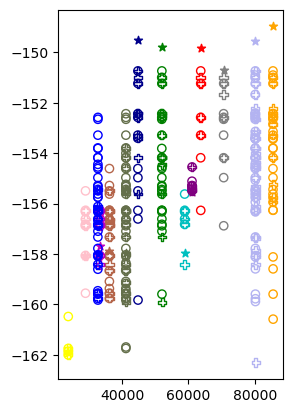

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# t0 = pd.Timestamp(2019, 8, 28, 17, 10)
# t1 = pd.Timestamp(2019, 8, 28, 17, 20)
t0 = pd.Timestamp(2018, 7, 3, 0, 0)
t1 = pd.Timestamp(2018, 7, 3, 0, 30)
picks_1 = picks_syn[(picks_syn["timestamp"] >= t0)]
picks_1 = picks_1[(picks_1["timestamp"] < t1)]
# picks_syn = picks_syn.merge(stations, "outer", on="id")
picks_syn['timediff'] = picks_syn['timestamp'].apply(lambda x: x - t0)
picks_syn = picks_syn.astype({'timediff':'timedelta64[s]'})
catalogs['timestamp'] = catalogs['time'].apply(lambda x: pd.Timestamp(x))
catalogs['timediff'] = catalogs['timestamp'].apply(lambda x: x - t0)
catalogs = catalogs.astype({'timediff':'timedelta64[s]'})
# event_syn['timestamp'] = event_syn['time'].apply(lambda x: pd.Timestamp(x[:-1]))
event_syn['timediff'] = event_syn['time'].apply(lambda x: x - t0)
event_syn = event_syn.astype({'timediff':'timedelta64[s]'})

# plt.figure(figsize=(4,3))
plt.subplot(1,2,1)
color = ['#646F4B', '#b3b3f1', '#b4654a', 'c', 'm', 'blue', 'orange', 'yellow', 'green', 'red', 'purple', 'pink', 'darkblue', 'gray']
p = picks_syn[picks_syn['type']=='P']
s = picks_syn[picks_syn['type']=='S']
for idx, eid in enumerate(set(picks_syn['evid'])):
    plt.scatter(p[p['evid'] == eid]["timediff"], p[p['evid'] == eid]["longitude"], marker = 'o', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(s[s['evid'] == eid]["timediff"], s[s['evid'] == eid]["longitude"], marker = 'P', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(event_syn[event_syn['evid'] == eid]['timediff'], event_syn[event_syn['evid'] == eid]['longitude'], marker = '*', edgecolors = color[idx], facecolors = color[idx])
plt.xlim(left = 0)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Time (s)', fontsize = 8)
plt.ylabel('longitude', fontsize = 8)
plt.title('ACE Catalog', fontsize = 8)
plt.ylim(bottom = -164, top = -148)
plt.subplot(1,2,2)
plt.scatter(p[p['event_index'] == -1]["timediff"], p[p['event_index'] == -1]["longitude"], marker = 'o', edgecolors = 'k', facecolors = 'none')
plt.scatter(s[s['event_index'] == -1]["timediff"], s[s['event_index'] == -1]["longitude"], marker = 'P', edgecolors = 'k', facecolors = 'none')
picks_syn = picks_syn[picks_syn['event_index']!= -1]
for idx, eid in enumerate(set(picks_syn['event_index'])):
    plt.scatter(p[p['event_index'] == eid]["timediff"], p[p['event_index'] == eid]["longitude"], marker = 'o', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(s[s['event_index'] == eid]["timediff"], s[s['event_index'] == eid]["longitude"], marker = 'P', edgecolors = color[idx], facecolors = 'none')
    plt.scatter(catalogs[catalogs['event_index'] == eid]['timediff'], catalogs[catalogs['event_index'] == eid]['longitude'], marker = '*', edgecolors = color[idx], facecolors = color[idx])
# plt.xlim(left = 0, right = 300)
plt.yticks([])
plt.xticks(fontsize = 8)
plt.xlabel('Time (s)', fontsize = 8)
pmiss = len(p[p['event_index'] == -1])
smiss = len(s[s['event_index'] == -1])
plt.title(f'GaMMA prediction ({pmiss}/{smiss} missed)', fontsize = 8)
plt.xlim(left = 0)
plt.ylim(bottom = -164, top = -148)
# plt.savefig('example10.pdf', format = 'pdf', bbox_inches = "tight")

# Parallel

In [4]:
import multiprocessing as mp
import pandas as pd

In [3]:
df = pd.DataFrame()

In [4]:
mgr = mp.Manager()
ns = mgr.Namespace()
ns.df = df

In [7]:
ns.df

""


In [9]:
import os
from itertools import repeat
def f(x, ns, lock, a):
    with lock:
        a.value += x
        ns.append([x]*x)
        print('Process id:', os.getpid(), x, len(ns), '\n')

manager = mp.Manager()
lock = manager.Lock()
ns = manager.list([])
a = manager.Value('i', 5)

with mp.Pool(3) as p:
    # issue a task to the process pool
    p.starmap(f, zip([1,2,3], repeat(ns), repeat(lock), repeat(a)))

Process id: 10968 1 1 

Process id: 10973 2 2 

Process id: 10968 3 3 



In [10]:
a.value

11

In [33]:
a = manager.Value('i', 5)

In [64]:
[iter(['a', 'b', 'c'])] * 2

[<list_iterator at 0x2af98165cbe0>, <list_iterator at 0x2af98165cbe0>]

In [58]:
list(zip([1,2,3][:, newaxis], ['a', 'b', 'c']*3))

<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_2645/1397164103.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  list(zip([1,2,3][:, newaxis], ['a', 'b', 'c']*3))
/tmp/ipykernel_2645/1397164103.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  list(zip([1,2,3][:, newaxis], ['a', 'b', 'c']*3))
/tmp/ipykernel_2645/1397164103.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  list(zip([1,2,3][:, newaxis], ['a', 'b', 'c']*3))


NameError: name 'newaxis' is not defined

In [25]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
client = Client("IRIS")
st2 = client.get_waveforms("XO", "KT10", "*", "?H?", UTCDateTime('20190101T000000Z'), UTCDateTime('20190201T001000Z'))

In [32]:
st2

27 Trace(s) in Stream:

AV.PVV..SHE | 2019-01-01T00:00:00.008000Z - 2019-01-07T04:24:44.468000Z | 50.0 Hz, 26714224 samples
...
(25 other traces)
...
AV.PVV..SHZ | 2019-01-29T18:03:54.488000Z - 2019-02-01T00:09:59.988000Z | 50.0 Hz, 9738276 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [12]:
locl = [tr.stats.location for tr in st]

In [15]:
set(locl)[0]

TypeError: 'set' object is not subscriptable

In [40]:
a = client.get_stations(network='AV', station='PLK5', channel="*", starttime = UTCDateTime('20190101T000000Z'), endtime=UTCDateTime('20190131T001000Z'), level="response")

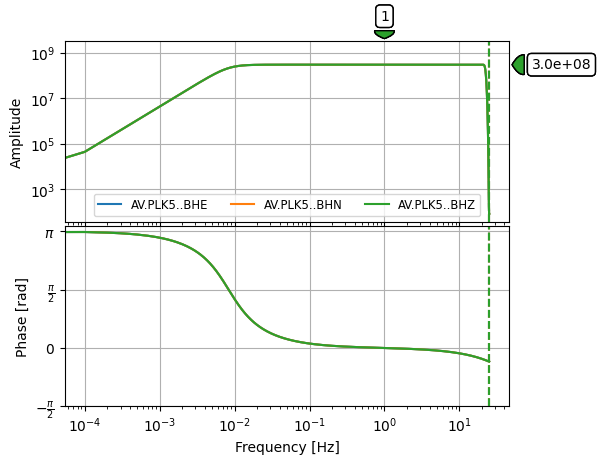

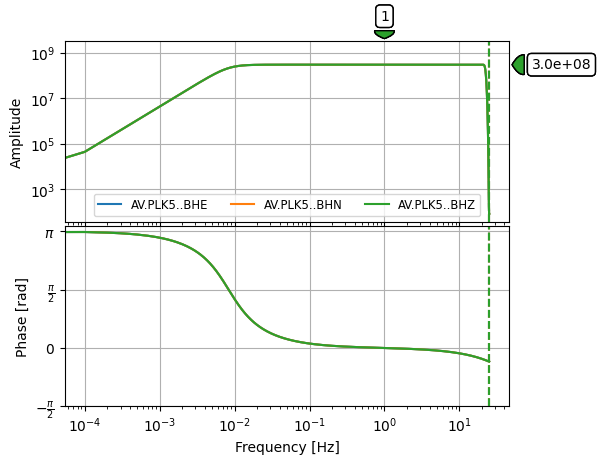

In [41]:
a[0].plot_response(min_freq=1e-4)

In [39]:
a[0]

Network AV (Alaska Volcano Observatory (AVO))
	Station Count: 1/290 (Selected/Total)
	1988-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			AV.PLK5 (Mt. Peulik Volcano 5, Alaska)
		Channels (0):
